In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates.angles import rotation_matrix
from astropy.table import Table
from astropy.cosmology import WMAP9
from astropy import constants as cnst

import data_loaders, detectability

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [3]:
#from erikutils import vlsr_to_vgsr

@u.quantity_input(vlsr=u.km/u.s, vrot=u.km/u.s)
def vlsr_to_vgsr(coord, vlsr=0*u.km/u.s, vrot=220*u.km/u.s):
    """
    Convert Local Standard of Rest radial velocity to galactocentric velocity

    Parameters
    ----------
    coord : SkyCoord
        The direction at which to compute the conversion factor.
    vlsr : Quantity with velocity units
        The heliocentric radial velocity.  Should be a scalar quantity or match the shape of `coord`.
    vrot : Quantity with velocity units
        The value of the galactic rotation curve at the solar cycle. The default is the IAU convention of 220 km/s.

    Returns
    -------
    vlsr : Quantity
        The velocity in the Local Standard of Rest frame.
    """
    # this adds the projection along the l=90, b=0 axis.  Could do the whole vector approach as above
    # but along the axis makes it trivial to do this simpler version
    l = coord.galactic.l
    b = coord.galactic.b
    return vlsr + vrot * np.sin(l) * np.cos(b)

def vrad_to_vopt(vrad):
    return vrad/(1-vrad/cnst.c)

# Load Data 

In [4]:
ml = Table.read('masterlist.csv', format='ascii')
m31 = SkyCoord(SkyCoord.from_name('M31'), distance=750*u.kpc)

In [5]:
# from Jen
vla_targs = """
# name RA Dec veldefs velocity
a18    11:28:56    6:25:29    LSRK_Radio    181
a28    13:13:22    10:12:57    LSRK_Radio    185
a36     15:04:41    6:12:59    LSRK_Radio    163
a39     15:10:01    11:11:27    LSRK_Radio    222
a41     15:55:07    14:29:29    LSRK_Radio    161
a47     16:22:36    5:08:48    LSRK_Radio    -123
a49     21:54:06    31:12:49    LSRK_Radio    -311
a50     21:58:03    28:37:35    LSRK_Radio    -426
a51     22:01:01    24:44:04    LSRK_Radio    -334
a54     22:21:34    24:36:38    LSRK_Radio    -330
a55     22:38:23    31:52:57    LSRK_Radio    -311
a6     01:49:52    29:26:00    LSRK_Radio    -327
destry1  00:14:45    10:49:00    LSRK_Radio    235.38 
destry11     6:43:33     9:13:00    LSRK_Radio    310.11
destry12     6:57:37     4:07:00    LSRK_Radio    -157.2
destry14     9:48:05    7:08:00    LSRK_Radio    526.31
destry15     10:48:25     12:31:00    LSRK_Radio    435.67
destry23     22:07:06    20:59:00    LSRK_Radio    303.48
destry24     22:36:06    9:02:00    LSRK_Radio    -236.64
destry25     22:46:58    7:41:00    LSRK_Radio    -234.09
destry26     22:48:26    20:33:00    LSRK_Radio    208.14
destry27     22:59:58    7:01:00    LSRK_Radio    -244.33
destry3     2:58:57    1:37:00    LSRK_Radio    528.59
destry4     4:14:57    33:18:00    LSRK_Radio    447.77
destry5     5:37:33    24:02:00    LSRK_Radio    153.04
destry6     5:45:45    31:46:00    LSRK_Radio    612.27
destry7     5:45:45     10:46:00    LSRK_Radio    614.53
destry8     6:03:37     30:53:00    LSRK_Radio    267.56
destry9     6:08:33     9:29:00    LSRK_Radio    584.58
""".strip()
vla_targs = Table.read(vla_targs, format='ascii.commented_header')

In [6]:
sc = SkyCoord(vla_targs['RA'], vla_targs['Dec'], unit=(u.hour, u.deg))
vgsr_opt = vlsr_to_vgsr(sc, vrad_to_vopt(vla_targs['velocity']*u.km/u.s))
vla_targs['distance'] = d = WMAP9.luminosity_distance((vgsr_opt/cnst.c).decompose())
vla_targs['skycoord'] = SkyCoord(vla_targs['RA'], vla_targs['Dec'], unit=(u.hour, u.deg), distance=d)

# First do the various completion limits

In [7]:
msk = (ml['distance']>0)&(ml['distance']<15)
mml = ml[msk]
mlsc = SkyCoord(mml['RA']*u.deg, mml['Dec']*u.deg, distance=Distance(mml['distance'], u.Mpc))
mlcart = mlsc.cartesian
mlgcart = mlsc.galactic.cartesian
Kabsm = mml['K'] - mlsc.distance.distmod.value

In [8]:
twomasslimit = 13.5*u.mag-Distance(2**0.5*10*u.Mpc).distmod
mlgcomplmsk = Kabsm < twomasslimit.value
twomasslimit

<Quantity -17.252574989159953 mag>

# Now the rotations to get certain orientations of the nearby data

In [9]:
#local void direction
local_void_sc = SkyCoord('18h38m', '18d')

local_void_xyz = local_void_sc.galactic.cartesian.xyz
x = mlgcart.x
y = mlgcart.y
z = mlgcart.z

In [10]:
mat1 = rotation_matrix(-local_void_sc.galactic.b, 'y')
mat2 = rotation_matrix(local_void_sc.galactic.l, 'z')
R1 = mat1 * mat2

zlv, xlv, ylv = np.dot(R1.A, [x,y,z]) # the above transform sends the *x* axis to the LV axis

targs = vla_targs['skycoord'][vla_targs['distance']>0]
ztargs, ytargs, xtargs = np.dot(R1.A, [targs.galactic.cartesian.x, targs.galactic.cartesian.y, targs.galactic.cartesian.z])

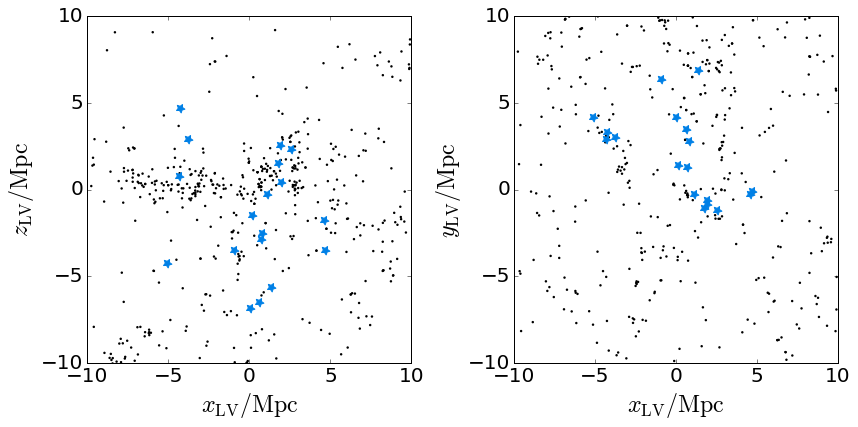

In [11]:
plt.figure(figsize=(12,6))
labelfontsz = 24
tickfontsz = 20
ptscolor = 'k'
targcolor = (0.,0.5,0.9)

plt.subplot(1,2,1)
plt.scatter(xlv[mlgcomplmsk], zlv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter(xtargs, ztargs, color=targcolor, marker=(5, 1, 45), s=80, zorder=2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.subplot(1,2,2)
plt.scatter(xlv[mlgcomplmsk], ylv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter(xtargs, ytargs, color=targcolor, marker=(5, 1, 45), s=80, zorder=2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.tight_layout()

# What about accounting for the GALFA footprint? 

In [12]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, _, galfa_sens_wcs, _ = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [13]:
#estimate gas mass

lKsmass = (mml['K']-3.28-Distance(mml['distance'], u.Mpc).distmod.value)/-2.5 + np.log10(0.5) #K-band M/L ~ 0.5
lrsmass = (mml['r']-4.67-Distance(mml['distance'], u.Mpc).distmod.value)/-2.5 + np.log10(1)#r-band M/L ~ 1

lsmass = np.zeros(len(lKsmass))
lsmass[~lKsmass.mask] = lKsmass[~lKsmass.mask]
lsmass[~lrsmass.mask] = lrsmass[~lrsmass.mask]
gmass = detectability.bradford_15_mstar_to_mgas(10**lsmass * u.solMass)
gmass[lsmass==0] = 0

In [14]:
_, in_survey, detectable = detectability.compute_detectability(galfa_sens, galfa_sens_wcs, mlsc, gmass)

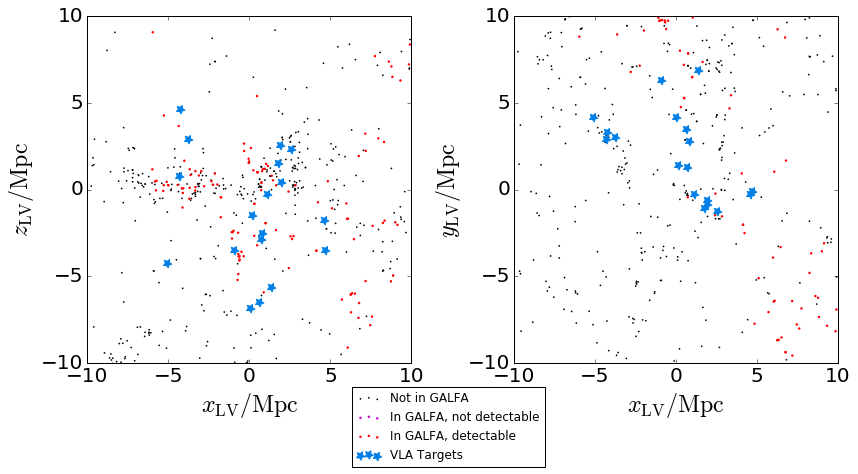

In [15]:
plt.figure(figsize=(12,6))
labelfontsz = 24
tickfontsz = 20
targcolor = (0.,0.5,0.9)

det_msk = detectable
notdet_msk = in_survey&~detectable
other_msk = ~in_survey
ptscolor_det = 'r'
ptscolor_notdet = 'm'
ptscolor_other = 'k'
ptssz_other = 3
ptssz_notdet = ptssz_det = 6

plt.subplot(1,2,1)
plt.scatter(xlv[mlgcomplmsk&other_msk], zlv[mlgcomplmsk&other_msk], edgecolor='none', s=ptssz_other, facecolor=ptscolor_other)
plt.scatter(xlv[mlgcomplmsk&notdet_msk], zlv[mlgcomplmsk&notdet_msk], edgecolor='none', s=ptssz_notdet, facecolor=ptscolor_notdet)
plt.scatter(xlv[mlgcomplmsk&det_msk], zlv[mlgcomplmsk&det_msk], edgecolor='none', s=ptssz_det, facecolor=ptscolor_det)
plt.scatter(xtargs, ztargs, color=targcolor, marker=(5, 1, 45), s=80, zorder=2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.subplot(1,2,2)
plt.scatter(xlv[mlgcomplmsk&other_msk], ylv[mlgcomplmsk&other_msk], 
            edgecolor='none', s=ptssz_other, facecolor=ptscolor_other, label='Not in GALFA')
plt.scatter(xlv[mlgcomplmsk&notdet_msk], ylv[mlgcomplmsk&notdet_msk], 
            edgecolor='none', s=ptssz_notdet, facecolor=ptscolor_notdet, label='In GALFA, not detectable')
plt.scatter(xlv[mlgcomplmsk&det_msk], ylv[mlgcomplmsk&det_msk], 
            edgecolor='none', s=ptssz_det, facecolor=ptscolor_det, label='In GALFA, detectable')
plt.scatter(xtargs, ytargs, color=targcolor, marker=(5, 1, 45), s=80, zorder=2, label='VLA Targets')

plt.legend(loc=(-.5,-.3))

plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.tight_layout()

# Now lets try a 3D view just to see what this looks like 

In [16]:
# this is "DR2" because it has fewer "gaps"
res = data_loaders.load_galfa_sensitivity('onempc_mass_sensalldata.fits.gz')
galfa2_sens, _, galfa2_sens_wcs, _ = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [17]:
_, in_survey2, detectable2 = detectability.compute_detectability(galfa2_sens, galfa2_sens_wcs, mlsc, gmass)

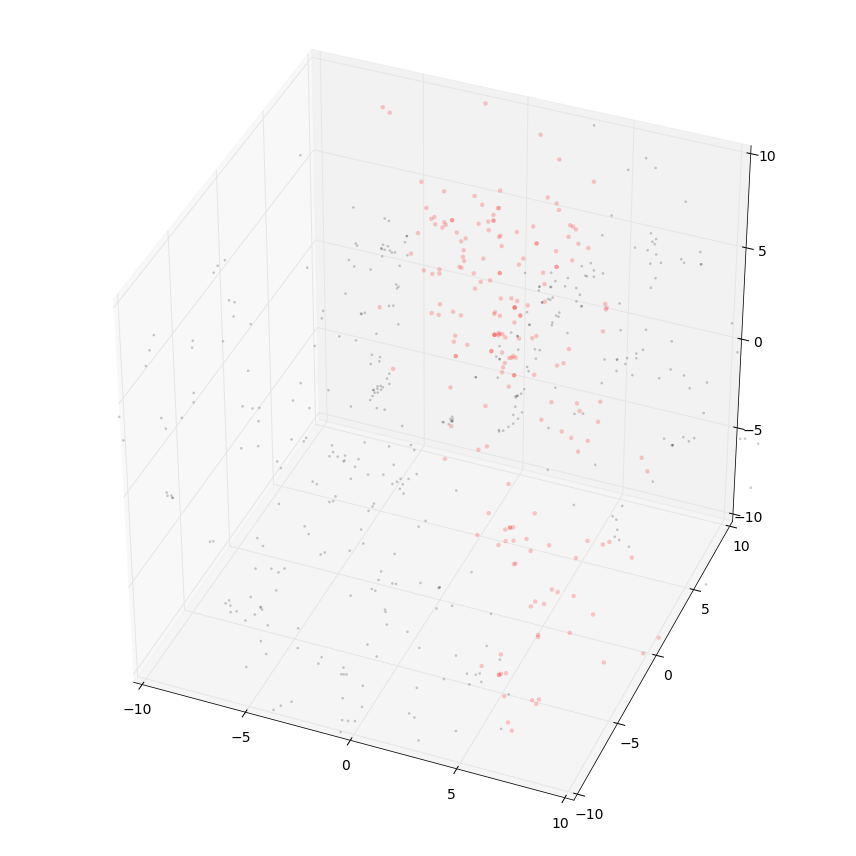

In [18]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')
ax.scatter3D(xlv[mlgcomplmsk&in_survey2], ylv[mlgcomplmsk&in_survey2], zlv[mlgcomplmsk&in_survey2], 
             c='r',s=20, alpha=.2, lw=0)
ax.scatter3D(xlv[mlgcomplmsk&~in_survey2], ylv[mlgcomplmsk&~in_survey2], zlv[mlgcomplmsk&~in_survey2], 
             c='k',s=7, alpha=.2, lw=0)

ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(-10, 10)

ax.azim = -68
ax.elev = 37

plt.tight_layout()